# Предсказание времени выхода на вакуум

Имеем [установку вакуумного напыления](https://ru.wikipedia.org/wiki/Вакуумное_напыление)
Любые действия с установкой происходят в технологических процессах (откача воздуха, подача газа и тп). Данные этих процессов можно получить путем создания рапортов в формате pdf(другие в доисторические времена создания ПО установки не были предусмотрены). Данные представляют собой временные ряды показаний датчиков.

[Обработка pdf файлов](https://github.com/denis-kaikov/Projects_data_science/blob/main/processing.ipynb) и [исходники](https://drive.google.com/file/d/1YgEZc9BlaqTOTYP-6VV-PXDJczhGn_lT/view?usp=drive_link)


Здесь уже работаем с файлом [data.csv](https://drive.google.com/file/d/1YgEZc9BlaqTOTYP-6VV-PXDJczhGn_lT/view?usp=drive_link) имеющий следущие поля
- Date(datetime): дата соотвествующей записи
- Upper верхняя граница задания давления (в начале любого процесса кроме "атмосферы" в камере будет достигаться такое давление, и только по достижению будут производится следущие действия)
- Lower нижняя граница задания давления (давление в камере поддерживается выше этой отметки, не используется)
- Pressure давление в камере
- Lg логарифм давления в камере
- Temp_NR1 температура крионасоса(начинает откачку по достижению 10К)
- RVL давление форвакуумной линии
- NR1 давление в крионасосе
- id идентификатор процесса
- Temp температура в камере


Всего используются два насоса для откачки воздуха: форвакуумный и криогенный(крионасос). Форвакуумный производит откачку в камере от атмосферы до 5 Па (больше едва ли у него получится), дальше начинает работать крионасос. Он производит откачку до высоког вакуума соотвественной установке Upper

Так же для доступа к содержимому камеры необходимо произвести напуск(выровнить давление в камере с окружающей средой)
для этого используется технический процесс "атмосфера", нас он не интересует 

Цель модели: предсказывать примерное время достижения границы Upper
модель интегрируется в проект в Master scada 4d с использованием C#, период опроса которой 100мс из за этого и малого количества данных отпадает использование DL

Для начала подгрузим данные проверим на пропуски и начнем формировать удобную для обучения таблицу


In [14]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from ydata_profiling import ProfileReport
%matplotlib inline

In [15]:
# пу пу пу фиксируем сид и пакеты для воспроизводимости
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [16]:
data = pd.read_csv("data/data.csv", index_col=0)
data["Date"] = pd.to_datetime(data["Date"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232985 entries, 0 to 232984
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Date      232985 non-null  datetime64[ns]
 1   Upper     232985 non-null  float64       
 2   Lower     232985 non-null  float64       
 3   Pressure  232985 non-null  float64       
 4   Lg        232985 non-null  float64       
 5   Temp_NR1  232985 non-null  float64       
 6   RVL       232985 non-null  float64       
 7   NR1       232985 non-null  float64       
 8   id        232985 non-null  int64         
 9   Temp      232985 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 19.6 MB


In [17]:
# в течении выполнения процесса пользователи могут поменять верхнюю границу,
# поэтому добавляем минимальное значение верхней границы для каждого процесса
table = data.groupby("id")["Upper"].min()
data["upper_min"] = data["id"].apply(lambda x: table[x])
data.describe()

Date          Upper     Lower       Pressure  \
count                         232985  232985.000000  232985.0  232985.000000   
mean   2025-09-17 04:35:47.277078272       1.207350       0.0    4411.588070   
min              2025-03-17 12:35:05       0.000100       0.0       0.000100   
25%              2025-09-11 16:53:40       0.003000       0.0       0.006270   
50%              2025-10-17 10:06:20       0.005000       0.0       0.749030   
75%              2025-10-29 09:25:34       2.000000       0.0      13.915540   
max              2025-11-14 15:29:05       5.000000       0.0  100000.000000   
std                              NaN       1.921015       0.0   20091.015179   

                  Lg       Temp_NR1            RVL            NR1  \
count  232985.000000  232985.000000  232985.000000  232985.000000   
mean       -0.291462      40.493580   58672.717584       0.984874   
min        -4.000000       4.270000       2.037000       0.692000   
25%        -2.208000      10.185000   59979.108000       0.711000   
50%        -0.131000      10.360000   66221.650000       0.714000   
75%         1.114000      12.425000   77446.180000       0.753000   
max         5.000000     288.050000  128233.058000      22.336000   
std         2.081250      60.918625   28415.371000       1.018701   

                  id           Temp      upper_min  
count  232985.000000  232985.000000  232985.000000  
mean      283.593184      39.091834       0.085751  
min         0.000000       0.000000       0.000100  
25%       227.000000      26.600000       0.003000  
50%       299.000000      28.400000       0.003000  
75%       348.000000      31.200000       0.005000  
max       432.000000    6542.500000       5.000000  
std        94.400917      40.665087       0.591573

Итак, необходимо по имеющейся информации предсказывать время выхода на вакуум(обычно 0.005 Па)
Пока данные представлены временными рядами в которых есть разрывы(ну выключили установку, соответсвенно записывать нечему)
целевая переменная будет представлять время от начала процесса до значений ниже upper Па(вакуум)
Важно есть нулевые значения в колонке Temp, так как датчик был подключен 11 апреля, их заполним средним


In [18]:
df = data.groupby("id", as_index=False)["Pressure"].aggregate([max, min])
df = df.merge(data.groupby("id")["Upper"].min(), on="id")
df = df.merge(data.groupby("id")["Date"].min(), on="id")
df = df.merge(data.groupby("id")["Date"].max(), on="id")
df = df.merge(data[data["Pressure"] == 100000].groupby(
    "id")["Date"].max(), on="id", how='left')
df = df.merge(data[data["Pressure"] == 100000].groupby("id")[
              "Date"].min(), on="id", suffixes=("", "atm_start"), how='left')
df.columns = ["id", "Pressure_max", "Pressure_min",
              "Upper_min", "start", "stop", "atm_end", "atm_start"]

df = df.merge(data[data["Pressure"] <= data["upper_min"]].groupby(
    "id")["Date"].min(), on="id", how="left")
df["delta"] = df.Date - df.start
df.columns = ["id", "Pressure_max", "Pressure_min", "Upper_min",
              "start", "stop", "atm_end", "atm_start", "vac_start", "delta"]

# здесь мы сформировали признак отвечающий за время с предыдущего процесса,
# это важно потому, что чем камера стоит открытая(давление в ней 100000Па), тем дольше будет достигаться вакуум
df["procces_delta"] = df["start"]-df["stop"].shift(1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   id             415 non-null    int64          
 1   Pressure_max   415 non-null    float64        
 2   Pressure_min   415 non-null    float64        
 3   Upper_min      415 non-null    float64        
 4   start          415 non-null    datetime64[ns] 
 5   stop           415 non-null    datetime64[ns] 
 6   atm_end        248 non-null    datetime64[ns] 
 7   atm_start      248 non-null    datetime64[ns] 
 8   vac_start      331 non-null    datetime64[ns] 
 9   delta          331 non-null    timedelta64[ns]
 10  procces_delta  414 non-null    timedelta64[ns]
dtypes: datetime64[ns](5), float64(3), int64(1), timedelta64[ns](2)
memory usage: 35.8 KB


можно заметить есть процессы в которых начальное давление было ниже 100000, и те, в которых давление не достигало вакуума, от вторых процессов мы избавляемся

In [20]:
df = df.drop(["atm_start", "atm_end"], axis=1)
df = df.dropna()
df = df.merge(data.groupby("id")["Pressure"].first(), on="id", how="left")
df = df.merge(data.groupby("id")["Temp_NR1"].first(), on="id", how="left")
df = df.merge(data.groupby("id")["RVL"].first(), on="id", how="left")
df = df.merge(data.groupby("id")["NR1"].first(), on="id", how="left")
df = df.merge(data.groupby("id")["Temp"].first(), on="id", how="left")
df = df.drop(["id", "Pressure_max", "Pressure_min",
             "start", "stop", "vac_start"], axis=1)

In [21]:
df["delta"] = df["delta"].dt.seconds
df["procces_delta"] = df["procces_delta"].dt.seconds/60
# заполняем нули в графе температуры
mean_temp = df[df["Temp"] > 0]["Temp"].mean()
df["Temp"] = df["Temp"].apply(lambda x: mean_temp if x == 0 else x)

Для быстрого знакомства с данными воспользуемся YData Profiling Report
[тык](https://html-preview.github.io/?url=https://github.com/denis-kaikov/Projects_data_science/blob/main/report.html)

In [22]:
report = ProfileReport(df)
report.to_file("report.html")
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 25096.81it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

построим доп графики, так как в interactions не все графики информативны

In [23]:
from statsmodels.stats.descriptivestats import sign_test
from scipy import stats
alpha = 0.05


# функция для принятия решения о нормальности

def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


def automatic_test(*args, rel: bool = False, alternative: str = "two-sided", popmean: float = 0):
    """функция автоматически проводит проверку на нормальность на основе заданого
    уровня значимости и в зависимости от длины исходного масива и значения rel проводит соответствующий тест


    Args:
        args (pd.series or list of pd.series): данные для теста
        rel (bool, optional): зависимы ли данные или нет. Defaults to False.
        alternative (str, optional) альтернативная гипотеза {‘two-sided’, ‘less’, ‘greater’}
        popmean (float, optional) мат ожидание для одновыборочного критерия
    """

    # проверяем является ли каждая в отдельности выборка нормально распределенной, True будет записано в переменную если все выборки одновременно нормально распределенны
    is_gaus = []
    for i in range(len(args)):
        is_gaus.append(stats.shapiro(args[i])[1] > alpha)
    is_gaus = sum(is_gaus) == len(args)

    if len(args) == 1:
        # одновыборочные тесты
        if is_gaus > alpha:
            print("Данные распределенны нормально, проводим одновыборочный t-тест")
            _, p_value = stats.ttest_1samp(
                *args, popmean=popmean, alternative=alternative)
        else:
            print("Данные распределенны ненормально, используем критерий знаков")
            _, p_value = sign_test(args, popmean)
    elif len(args) == 2:
        # двухвыборочные тесты
        if is_gaus > alpha:
            if rel:
                print("Данные распределенны нормально, проводим парный t-тест")
                _, p_value = stats.ttest_rel(
                    args[0], args[1], alternative=alternative)
            else:
                print("Данные распределенны нормально, проводим двухвыборочный t-тест")
                # проверка на равенство дисперсий
                eq_var = stats.levene(*args)[1] > alpha
                _, p_value = stats.ttest_ind(
                    args[0], args[1], alternative=alternative, equal_var=eq_var)
        else:
            if rel:
                print("Данные распределенны ненормально, проводим тест Уилкинсона")
                _, p_value = stats.wilcoxon(
                    args[0], args[1], alternative=alternative)
            else:
                print("Данные распределенны ненормально, проводим тест Манна-Уитни")
                _, p_value = stats.mannwhitneyu(
                    args[0], args[1], alternative=alternative)
    elif len(args) >= 3:
        # тесты для нескольких выборок
        # проверка на равенство дисперсий
        eq_var = stats.levene(*args)[1] > alpha
        if is_gaus > alpha and eq_var and not rel:
            print("Данные распределенны нормально, проводим Anova")
            _, p_value = stats.f_oneway(*args)
        else:
            if rel:
                print("Данные распределенны ненормально, проводим тест Фридмана")
                _, p_value = stats.friedmanchisquare(*args)
            else:
                print(
                    "Данные распределенны ненормально, проводим тест Краскела-Уоллиса ")
                _, p_value = stats.kruskal(*args)
    print('p-value = {:.3f}'.format(p_value))
    if p_value <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

Мне кажется, что из за распределений признаков целесообразно использовать деревья решений, а линейную модель как базовую модель 

In [24]:
table = df[(df["Upper_min"] < 0.01) & (
    df["delta"] > 0) & (df["Temp_NR1"] < 20)]
ax = sns.boxplot(data=table, x="delta", y="Upper_min", orient="h")
ax.set_title("время откачки от велечины верхней границы")

Text(0.5, 1.0, 'время откачки от велечины верхней границы')

Здесь все по графику понятно, хотелось более наглядного отображения зависимости времени от верхней границы
Чем ниже граница установлена, тем больше времени уходит на откачку

Text(0.5, 1.0, 'время откачки в зависимости от того, прошло больше/меньше 600 минут от предыдущего процесса')

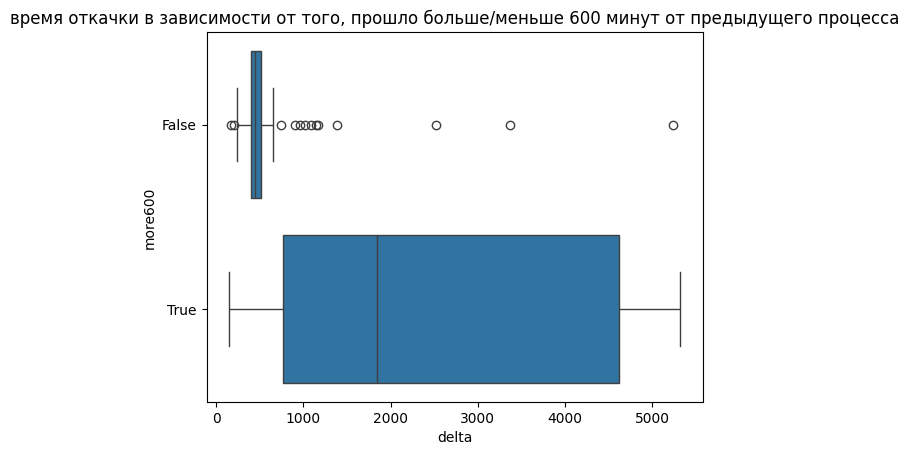

In [25]:
table = df[(df["Pressure"] > 5) & (df["Upper_min"] == 0.005)]
table["more600"] = df["procces_delta"] > 600
ax = sns.boxplot(data=table, x="delta", y="more600", orient="h")
ax.set_title(
    "время откачки в зависимости от того, прошло больше/меньше 600 минут от предыдущего процесса")

Что важно отметить:
- виден разрыв данных от 400 до 1000 минут, связано с тем, что установка ночью не работает
- не вооруженным взглядом видно, что распределения отличаются, после долгого простоя на откачку уходит больше времени
- необходимо проверить, тк данных с procces_delta > 600 меньше


In [26]:
# нулевая гипотеза: распределения не отличаются
# альтернативная гипотеза: у процессов с с procces_delta > 600 время откачки в среднем больше
automatic_test(table[table["more600"]]["delta"],
               table[~table["more600"]]["delta"], alternative="greater")

Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Обучение модели

Для простой интерпритируемости выбрана метрика MAE, так же будет представлена RMSE для информативности

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [28]:

X = df.drop("delta", axis=1)
y = df["delta"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

На всякий случай попробуем использование линейных моделей, и модели с полиномиальными признаками

In [29]:
X_scaled = StandardScaler().fit_transform(X)
lin_model = LinearRegression()
scores = cross_validate(lin_model, X_scaled, y, cv=10, scoring=(
    "neg_root_mean_squared_error", "neg_mean_absolute_error"))
print(f"RMSE:{scores["test_neg_root_mean_squared_error"].mean()}")
print(f"MAE:{scores["test_neg_mean_absolute_error"].mean()}")

RMSE:-730.0323379261794
MAE:-404.81640060815596


In [30]:
X_scaled = StandardScaler().fit_transform(X)
X_poly = PolynomialFeatures(degree=2).fit_transform(X_scaled)
lin_model = Ridge(alpha=100)
scores = cross_validate(lin_model, X_poly, y, cv=10, scoring=(
    "neg_root_mean_squared_error", "neg_mean_absolute_error"))
print(f"RMSE:{scores["test_neg_root_mean_squared_error"].mean()}")
print(f"MAE:{scores["test_neg_mean_absolute_error"].mean()}")

RMSE:-763.2291740578144
MAE:-424.9278844006385


In [31]:
X_scaled = StandardScaler().fit_transform(X)
X_poly = PolynomialFeatures(degree=3).fit_transform(X_scaled)
lin_model = Ridge(alpha=1100)
scores = cross_validate(lin_model, X_poly, y, cv=10, scoring=(
    "neg_root_mean_squared_error", "neg_mean_absolute_error"))
print(f"RMSE:{scores["test_neg_root_mean_squared_error"].mean()}")
print(f"MAE:{scores["test_neg_mean_absolute_error"].mean()}")

RMSE:-811.018957824346
MAE:-468.92743468472025


Итого использование линейных моделей с добавлением полиномиальных признаков не добавляет точности

Будем пробовать использовать деревья решений и ансамбли над деревьями решений

In [32]:
model = DecisionTreeRegressor(random_state=42)
# scores = cross_validate(model, X, y, cv=10, scoring=("neg_root_mean_squared_error", "neg_mean_absolute_error"))
parameters = {"max_depth": range(2, 10), "min_samples_split": range(
    1, 10), "min_samples_leaf": range(1, 10)}

grid_search = GridSearchCV(model, parameters, cv=10,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(X, y)

# model.fit(X_train, y_train)

scores = cross_validate(grid_search.best_estimator_, X, y, cv=10, scoring=(
    "neg_root_mean_squared_error", "neg_mean_absolute_error"))
print(f"RMSE:{scores["test_neg_root_mean_squared_error"].mean()}")
print(f"MAE:{scores["test_neg_mean_absolute_error"].mean()}")

RMSE:-622.6604956271565
MAE:-305.8867147677073


In [33]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)
# scores = cross_validate(model, X, y, cv=10, scoring=("neg_root_mean_squared_error", "neg_mean_absolute_error"))
parameters = {"criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], "max_depth": range(
    2, 10), "min_samples_split": range(1, 10), "min_samples_leaf": range(1, 10)}

grid_search = GridSearchCV(model, parameters, cv=10, n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)

# model.fit(X_train, y_train)
scores = cross_validate(grid_search.best_estimator_, X, y, cv=10, scoring=(
    "neg_root_mean_squared_error", "neg_mean_absolute_error"))
print(f"RMSE:{scores["test_neg_root_mean_squared_error"].mean()}")
print(f"MAE:{scores["test_neg_mean_absolute_error"].mean()}")

Fitting 10 folds for each of 2592 candidates, totalling 25920 fits
RMSE:-614.4677023000123
MAE:-298.5332807486631


In [34]:
cat_model = CatBoostRegressor(random_seed=42, learning_rate=0.1, verbose=False)
parameters = {"depth": range(1, 10)}
grid_search = GridSearchCV(cat_model, parameters, cv=5,
                           n_jobs=-1, scoring="neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)
scores = cross_validate(grid_search.best_estimator_, X, y, cv=10, scoring=(
    "neg_root_mean_squared_error", "neg_mean_absolute_error"))
print(f"RMSE:{scores["test_neg_root_mean_squared_error"].mean()}")
print(f"MAE:{scores["test_neg_mean_absolute_error"].mean()}")

RMSE:-542.8158412279741
MAE:-292.7623366273172


In [36]:
model = GradientBoostingRegressor(random_state=42, learning_rate=0.1)
parameters = {"loss": ['squared_error', 'absolute_error', 'huber', 'quantile'], "max_depth": range(
    2, 10), "min_samples_split": range(1, 10), "min_samples_leaf": range(1, 10)}
grid_search = GridSearchCV(model, parameters, cv=5,
                           n_jobs=-1, scoring="neg_root_mean_squared_error")
grid_search.fit(X, y)

# model.fit(X_train, y_train)
scores = cross_validate(grid_search.best_estimator_, X, y, cv=10, scoring=(
    "neg_root_mean_squared_error", "neg_mean_absolute_error"))
print(f"RMSE:{scores["test_neg_root_mean_squared_error"].mean()}")
print(f"MAE:{scores["test_neg_mean_absolute_error"].mean()}")

RMSE:-521.4503200994155
MAE:-258.31988597626304


Итоги:
В целом, для текущей задачи, средняя ошибка в 4.5 минуты удовлетворительная, для дальнейшего увеличения точности необходимо увеличение количества данных

Дальнейшие действия следущие: берем лучшую модель, обучаем на всех данных, пакуем в joblib, используем модель в скрипте на C# в master scada 4d

In [ ]:
import joblib
model = GradientBoostingRegressor(
    random_state=42, learning_rate=0.1, **grid_search.best_params_)
model.fit(X, y)
joblib.dump(model, "model")

['model']